In [1]:
!pip install /kaggle/input/deepfake-detection-jph/facenet_pytorch-2.0.1-py3-none-any.whl
!cp -r /kaggle/input/pretrainedmodels /kaggle/working/; cd /kaggle/working/pretrainedmodels/pretrained-models.pytorch ; pip install .
#!pip install /kaggle/input/deepfake-detection-jph/efficientnet_pytorch-0.6.1/efficientnet_pytorch-0.6.1

Processing /kaggle/input/deepfake-detection-jph/facenet_pytorch-2.0.1-py3-none-any.whl
Processing /kaggle/working/pretrainedmodels/pretrained-models.pytorch
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=62050 sha256=8f8e4526a5aef82c54d25d3b4af49d9a49b95564fc334bbe1240c01b94de3f1c
  Stored in directory: /root/.cache/pip/wheels/bb/0d/6b/641c933975c8af664a1411d7ca20d0953bbce16797e76d515c
Successfully built pretrainedmodels


In [2]:
import os
import math
import pickle
from functools import partial
from collections import defaultdict

from PIL import Image
from glob import glob

import cv2
import numpy as np
import skimage.measure
import albumentations as A
from tqdm.notebook import tqdm 
from albumentations.pytorch import ToTensor 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.video import mc3_18, r2plus1d_18

from facenet_pytorch import MTCNN

In [3]:
# Input data
INPUT_DIR = "/kaggle/input/deepfake-detection-challenge/test_videos"
PRETRAINED_MODELS_3D = [{'type':'i3d',
                         'path':"/kaggle/input/deepfake-detection-jph/j3d_e1_l0.1374.model"},
                        {'type':'res34',
                         'path':"/kaggle/input/deepfake-detection-jph/res34_1cy_minaug_nonorm_e4_l0.1794.model"},
                        {'type':'mc3_112',
                         'path':"/kaggle/input/deepfake-detection-jph/mc3_18_112_1cy_lilaug_nonorm_e9_l0.1905.model"},
                        {'type':'mc3_224',
                         'path':"/kaggle/input/deepfake-detection-jph/mc3_18_112t224_1cy_lilaug_nonorm_e7_l0.1901.model"},
                        {'type':'r2p1_112',
                         'path':"/kaggle/input/deepfake-detection-jph/r2p1_18_8_112tr_112te_e12_l0.1741.model"},
                        {'type':'i3d',
                         'path':"/kaggle/input/deepfake-detection-jph/i3dcutmix_e11_l0.1612.model"},
                        {'type':'r2p1_112',
                         'path':"/kaggle/input/deepfake-detection-jph/r2plus1dcutmix_112_e10_l0.1608.model"}]

# Face detection
MAX_FRAMES_TO_LOAD = 100
MIN_FRAMES_FOR_FACE = 30
MAX_FRAMES_FOR_FACE = 100
FACE_FRAMES = 10
MAX_FACES_HIGHTHRESH = 5
MAX_FACES_LOWTHRESH = 1
FACEDETECTION_DOWNSAMPLE = 0.25
MTCNN_THRESHOLDS = (0.8, 0.8, 0.9)  # Default [0.6, 0.7, 0.7]
MTCNN_THRESHOLDS_RETRY = (0.5, 0.5, 0.5)
MMTNN_FACTOR = 0.71  # Default 0.709 p
TWO_FRAME_OVERLAP = False

# Inference
PROB_MIN, PROB_MAX = 0.001, 0.999
REVERSE_PROBS = True
DEFAULT_MISSING_PRED = 0.5
USE_FACE_FUNCTION = np.mean

# 3D inference
RATIO_3D = 1
OUTPUT_FACE_SIZE = (256, 256)
PRE_INFERENCE_CROP = (224, 224)

# 2D
RATIO_2D = 1

In [4]:
def load_video(filename, every_n_frames=None, specific_frames=None, to_rgb=True, rescale=None, inc_pil=False, max_frames=None):
    """Loads a video.
    Called by:
    
    1) The finding faces algorithm where it pulls a frame every FACE_FRAMES frames up to MAX_FRAMES_TO_LOAD at a scale of FACEDETECTION_DOWNSAMPLE, and then half that if there's a CUDA memory error.
    
    2) The inference loop where it pulls EVERY frame up to a certain amount which it the last needed frame for each face for that video"""
    
    assert every_n_frames or specific_frames, "Must supply either every n_frames or specific_frames"
    assert bool(every_n_frames) != bool(specific_frames), "Supply either 'every_n_frames' or 'specific_frames', not both"
    
    cap = cv2.VideoCapture(filename)
    n_frames_in = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width_in = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height_in = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    if rescale:
        rescale = rescale * 1920./np.max((width_in, height_in))
    
    width_out = int(width_in*rescale) if rescale else width_in
    height_out = int(height_in*rescale) if rescale else height_in
    
    if max_frames:
        n_frames_in = min(n_frames_in, max_frames)
    
    if every_n_frames:
        specific_frames = list(range(0,n_frames_in,every_n_frames))
    
    n_frames_out = len(specific_frames)
    
    out_pil = []

    out_video = np.empty((n_frames_out, height_out, width_out, 3), np.dtype('uint8'))

    i_frame_in = 0
    i_frame_out = 0
    ret = True

    while (i_frame_in < n_frames_in and ret):
        
        try:
            try:
        
                if every_n_frames == 1:
                    ret, frame_in = cap.read()  # Faster if reading all frames
                else:
                    ret = cap.grab()

                    if i_frame_in not in specific_frames:
                        i_frame_in += 1
                        continue

                    ret, frame_in = cap.retrieve()
                    
#                 print(f"Reading frame {i_frame_in}")

                if rescale:
                    frame_in = cv2.resize(frame_in, (width_out, height_out))
                if to_rgb:
                    frame_in = cv2.cvtColor(frame_in, cv2.COLOR_BGR2RGB)
                
            except Exception as e:
                print(f"Error for frame {i_frame_in} for video {filename}: {e}; using 0s")
                frame_in = np.zeros((height_out, width_out, 3))

        
            out_video[i_frame_out] = frame_in
            i_frame_out += 1

            if inc_pil:
                try:  # https://www.kaggle.com/zaharch/public-test-errors
                    pil_img = Image.fromarray(frame_in)
                except Exception as e:
                    print(f"Using a blank frame for video {filename} frame {i_frame_in} as error {e}")
                    pil_img = Image.fromarray(np.zeros((224,224,3), dtype=np.uint8))  # Use a blank frame
                out_pil.append(pil_img)

            i_frame_in += 1
            
        except Exception as e:
            print(f"Error for file {filename}: {e}")

    cap.release()
    
    if inc_pil:
        return out_video, out_pil, rescale
    else:
        return out_video, rescale

def get_roi_for_each_face(faces_by_frame, probs, video_shape, temporal_upsample, upsample=1):
    # Create boolean face array
    frames_video, rows_video, cols_video, channels_video = video_shape
    frames_video = math.ceil(frames_video)
    boolean_face_3d = np.zeros((frames_video, rows_video, cols_video), dtype=np.bool)  # Remove colour channel
    proba_face_3d = np.zeros((frames_video, rows_video, cols_video)).astype('float32')
    for i_frame, faces in enumerate(faces_by_frame):
        if faces is not None:  # May not be a face in the frame
            for i_face, face in enumerate(faces):
                left, top, right, bottom = face
                boolean_face_3d[i_frame, int(top):int(bottom), int(left):int(right)] = True
                proba_face_3d[i_frame, int(top):int(bottom), int(left):int(right)] = probs[i_frame][i_face]
                
    # Replace blank frames if face(s) in neighbouring frames with overlap
    for i_frame, frame in enumerate(boolean_face_3d):
        if i_frame == 0 or i_frame == frames_video-1:  # Can't do this for 1st or last frame
            continue
        if True not in frame:
            if TWO_FRAME_OVERLAP:
                if i_frame > 1:
                    pre_overlap = boolean_face_3d[i_frame-1] | boolean_face_3d[i_frame-2]
                else:
                    pre_overlap = boolean_face_3d[i_frame-1]
                if i_frame < frames_video-2:
                    post_overlap = boolean_face_3d[i_frame+1] | boolean_face_3d[i_frame+2]
                else:
                    post_overlap = boolean_face_3d[i_frame+1]
                neighbour_overlap = pre_overlap & post_overlap
            else:
                neighbour_overlap = boolean_face_3d[i_frame-1] & boolean_face_3d[i_frame+1]
            boolean_face_3d[i_frame] = neighbour_overlap

    # Find faces through time
    id_face_3d, n_faces = skimage.measure.label(boolean_face_3d, return_num=True)
    region_labels, counts = np.unique(id_face_3d, return_counts=True)
    # Get rid of background=0
    region_labels, counts = region_labels[1:], counts[1:]
    ###################
    # DESCENDING SIZE #
    ###################
    descending_size = np.argsort(counts)[::-1]
    labels_by_size = region_labels[descending_size]
    ####################
    # DESCENDING PROBS #
    ####################
    probs = [np.mean(proba_face_3d[id_face_3d == i_face]) for i_face in region_labels]
    descending_probs = np.argsort(probs)[::-1]
    labels_by_probs = region_labels[descending_probs]
    # Iterate over faces in video
    rois = [] ; face_maps = []
    for i_face in labels_by_probs:#labels_by_size:
        # Find the first and last frame containing the face
        frames = np.where(np.any(id_face_3d == i_face, axis=(1, 2)) == True)
        starting_frame, ending_frame = frames[0].min(), frames[0].max()

        # Iterate over the frames with faces in and find the min/max cols/rows (bounding box)
        cols, rows = [], []
        for i_frame in range(starting_frame, ending_frame + 1):
            rs = np.where(np.any(id_face_3d[i_frame] == i_face, axis=1) == True)
            rows.append((rs[0].min(), rs[0].max()))
            cs = np.where(np.any(id_face_3d[i_frame] == i_face, axis=0) == True)
            cols.append((cs[0].min(), cs[0].max()))
        frame_from, frame_to = starting_frame*temporal_upsample, ((ending_frame+1)*temporal_upsample)-1
        rows_from, rows_to = np.array(rows)[:, 0].min(), np.array(rows)[:, 1].max()
        cols_from, cols_to = np.array(cols)[:, 0].min(), np.array(cols)[:, 1].max()
        
        frame_to = min(frame_to, frame_from + MAX_FRAMES_FOR_FACE)
        
        if frame_to - frame_from >= MIN_FRAMES_FOR_FACE:
            tmp_face_map = id_face_3d.copy()
            tmp_face_map[tmp_face_map != i_face] = 0
            tmp_face_map[tmp_face_map == i_face] = 1
            face_maps.append(tmp_face_map[frame_from//temporal_upsample:frame_to//temporal_upsample+1])
            rois.append(((frame_from, frame_to),
                         (int(rows_from*upsample), int(rows_to*upsample)),
                         (int(cols_from*upsample), int(cols_to*upsample))))
            
    return np.array(rois), face_maps

# Find faces

In [5]:
def get_center(bbox):
    x1, y1, x2, y2 = bbox
    return (x1+x2)/2, (y1+y2)/2


def get_coords(faces_roi):
    coords = np.argwhere(faces_roi == 1)
    #print(coords)
    if coords.shape[0] == 0:
        return None
    y1, x1 = coords[0]
    y2, x2 = coords[-1]
    return x1, y1, x2, y2


def interpolate_center(c1, c2, length):
    x1, y1 = c1
    x2, y2 = c2
    xi, yi = np.linspace(x1, x2, length), np.linspace(y1, y2, length)
    return np.vstack([xi, yi]).transpose(1,0)


def get_faces(faces_roi, upsample): 
    all_faces = []
    rows = faces_roi[0].shape[1]
    cols = faces_roi[0].shape[2]
    for i in range(len(faces_roi)):
        faces = np.asarray([get_coords(faces_roi[i][j]) for j in range(len(faces_roi[i]))])
        if faces[0] is None:  faces[0] = faces[1]
        if faces[-1] is None: faces[-1] = faces[-2]
        if None in faces:
            #print(faces)
            raise Exception('This should not have happened ...')
        all_faces.append(faces)

    extracted_faces = []
    for face in all_faces:
        # Get max dim size
        max_dim = np.concatenate([face[:,2]-face[:,0],face[:,3]-face[:,1]])
        max_dim = np.percentile(max_dim, 90)
        # Enlarge by 1.2
        max_dim = int(max_dim * 1.2)
        # Get center coords
        centers = np.asarray([get_center(_) for _ in face])
        # Interpolate
        centers = np.vstack([interpolate_center(centers[i], centers[i+1], length=10) for i in range(len(centers)-1)]).astype('int')
        x1y1 = centers - max_dim // 2
        x2y2 = centers + max_dim // 2 
        x1, y1 = x1y1[:,0], x1y1[:,1]
        x2, y2 = x2y2[:,0], x2y2[:,1]
        # If x1 or y1 is negative, turn it to 0
        # Then add to x2 y2 or y2
        x2[x1 < 0] -= x1[x1 < 0]
        y2[y1 < 0] -= y1[y1 < 0]
        x1[x1 < 0] = 0
        y1[y1 < 0] = 0
        # If x2 or y2 is too big, turn it to max image shape
        # Then subtract from y1
        y1[y2 > rows] += rows - y2[y2 > rows]
        x1[x2 > cols] += cols - x2[x2 > cols]
        y2[y2 > rows] = rows
        x2[x2 > cols] = cols
        vidface = np.asarray([[x1[_],y1[_],x2[_],y2[_]] for _,c in enumerate(centers)])
        vidface = (vidface*upsample).astype('int')
        extracted_faces.append(vidface)

    return extracted_faces

def detect_face_with_mtcnn(mtcnn_model, pil_frames, facedetection_upsample, video_shape, face_frames):
    boxes, _probs = mtcnn_model.detect(pil_frames, landmarks=False)
    faces, faces_roi = get_roi_for_each_face(faces_by_frame=boxes, probs=_probs, video_shape=video_shape, temporal_upsample=face_frames, upsample=facedetection_upsample)
    coords = [] if len(faces_roi) == 0 else get_faces(faces_roi, upsample=facedetection_upsample)
    return faces, coords

def face_detection_wrapper(mtcnn_model, videopath, every_n_frames, facedetection_downsample, max_frames_to_load):
    video, pil_frames, rescale = load_video(videopath, every_n_frames=every_n_frames, to_rgb=True, rescale=facedetection_downsample, inc_pil=True, max_frames=max_frames_to_load)
    if len(pil_frames):
        try:
            faces, coords = detect_face_with_mtcnn(mtcnn_model=mtcnn, 
                                                   pil_frames=pil_frames, 
                                                   facedetection_upsample=1/rescale, 
                                                   video_shape=video.shape, 
                                                   face_frames=every_n_frames)
        except RuntimeError:  # Out of CUDA RAM
            print(f"Failed to process {videopath} ! Downsampling x2 ...")
            video, pil_frames, rescale = load_video(videopath, every_n_frames=every_n_frames, to_rgb=True, rescale=facedetection_downsample/2, inc_pil=True, max_frames=max_frames_to_load)

            try:
                faces, coords = detect_face_with_mtcnn(mtcnn_model=mtcnn, 
                                       pil_frames=pil_frames, 
                                       facedetection_upsample=1/rescale, 
                                       video_shape=video.shape, 
                                       face_frames=every_n_frames)
            except RuntimeError:
                print(f"Failed on downsample ! Skipping...")
                return [], []
                
    else:
        print('Failed to fetch frames ! Skipping ...')
        return [], []
        
    if len(faces) == 0:
        print('Failed to find faces ! Upsampling x2 ...')
        try:
            video, pil_frames, rescale = load_video(videopath, every_n_frames=every_n_frames, to_rgb=True, rescale=facedetection_downsample*2, inc_pil=True, max_frames=max_frames_to_load)
            faces, coords = detect_face_with_mtcnn(mtcnn_model=mtcnn, 
                                                   pil_frames=pil_frames, 
                                                   facedetection_upsample=1/rescale, 
                                                   video_shape=video.shape, 
                                                   face_frames=every_n_frames)
        except Exception as e:
            print(e)
            return [], []
    
    return faces, coords

In [6]:
videopaths = sorted(glob(os.path.join(INPUT_DIR, "*.mp4")))
print(f'Found {len(videopaths)} videos !')

mtcnn = MTCNN(margin=0, keep_all=True, post_process=False, select_largest=False, device='cuda:0', thresholds=MTCNN_THRESHOLDS, factor=MMTNN_FACTOR)

faces_by_videopath = {}
coords_by_videopath = {}

for i_video, videopath in enumerate(tqdm(videopaths)):
    faces, coords = face_detection_wrapper(mtcnn, videopath, every_n_frames=FACE_FRAMES, facedetection_downsample=FACEDETECTION_DOWNSAMPLE, max_frames_to_load=MAX_FRAMES_TO_LOAD)
            
    if len(faces):
        faces_by_videopath[videopath]  = faces[:MAX_FACES_HIGHTHRESH]
        coords_by_videopath[videopath] = coords[:MAX_FACES_HIGHTHRESH]
    else:
        print(f"Found no faces for {videopath} !")

        
del mtcnn
import gc
gc.collect()

videopaths_missing_faces = {p for p in videopaths if p not in faces_by_videopath}
print(f"Found faces for {len(faces_by_videopath)} videos; {len(videopaths_missing_faces)} missing")


Found 400 videos !


Failed to find faces ! Upsampling x2 ...
Found no faces for /kaggle/input/deepfake-detection-challenge/test_videos/bkcyglmfci.mp4 !
Failed to find faces ! Upsampling x2 ...
Found no faces for /kaggle/input/deepfake-detection-challenge/test_videos/hsbljbsgxr.mp4 !
Failed to find faces ! Upsampling x2 ...
Found no faces for /kaggle/input/deepfake-detection-challenge/test_videos/lebzjtusnr.mp4 !
Failed to find faces ! Upsampling x2 ...
Failed to find faces ! Upsampling x2 ...
Failed to find faces ! Upsampling x2 ...
Found no faces for /kaggle/input/deepfake-detection-challenge/test_videos/yllztsrwjw.mp4 !
Failed to find faces ! Upsampling x2 ...
Found no faces for /kaggle/input/deepfake-detection-challenge/test_videos/zgbhzkditd.mp4 !

Found faces for 395 videos; 5 missing


In [7]:
mtcnn = MTCNN(margin=0, keep_all=True, post_process=False, select_largest=False ,device='cuda:0', thresholds=MTCNN_THRESHOLDS_RETRY, factor=MMTNN_FACTOR)

for i_video, videopath in enumerate(tqdm(videopaths_missing_faces)):
    faces, coords = face_detection_wrapper(mtcnn, 
                                           videopath, 
                                           every_n_frames=FACE_FRAMES, 
                                           facedetection_downsample=FACEDETECTION_DOWNSAMPLE, 
                                           max_frames_to_load=MAX_FRAMES_TO_LOAD)
            
    if len(faces):
        faces_by_videopath[videopath]  = faces[:MAX_FACES_LOWTHRESH]
        coords_by_videopath[videopath] = coords[:MAX_FACES_LOWTHRESH]
    else:
        print(f"Found no faces for {videopath} !")

del mtcnn
import gc
gc.collect()

faces_by_videopath = dict(sorted(faces_by_videopath.items(), key=lambda x: x[0]))
videopaths_missing_faces = {p for p in videopaths if p not in faces_by_videopath}
print(f"Found faces for {len(faces_by_videopath)} videos; {len(videopaths_missing_faces)} missing")

Failed to find faces ! Upsampling x2 ...

Found faces for 400 videos; 0 missing


In [8]:
faces_by_videopath = dict(sorted(faces_by_videopath.items(), key=lambda x: x[0]))
videopaths_missing_faces = {p for p in videopaths if p not in faces_by_videopath}
print(f"Found faces for {len(faces_by_videopath)} videos; {len(videopaths_missing_faces)} missing")

Found faces for 400 videos; 0 missing


# 3D CNNs

In [9]:
class MaxPool3dSamePadding(nn.MaxPool3d):

    def compute_pad(self, dim, s):
        if s % self.stride[dim] == 0:
            return max(self.kernel_size[dim] - self.stride[dim], 0)
        else:
            return max(self.kernel_size[dim] - (s % self.stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        # print t,h,w
        out_t = np.ceil(float(t) / float(self.stride[0]))
        out_h = np.ceil(float(h) / float(self.stride[1]))
        out_w = np.ceil(float(w) / float(self.stride[2]))
        # print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        # print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        # print x.size()
        # print pad
        x = F.pad(x, pad)
        return super(MaxPool3dSamePadding, self).forward(x)


class Unit3D(nn.Module):

    def __init__(self, in_channels,
                 output_channels,
                 kernel_shape=(1, 1, 1),
                 stride=(1, 1, 1),
                 padding=0,
                 activation_fn=F.relu,
                 use_batch_norm=True,
                 use_bias=False,
                 name='unit_3d'):

        """Initializes Unit3D module."""
        super(Unit3D, self).__init__()

        self._output_channels = output_channels
        self._kernel_shape = kernel_shape
        self._stride = stride
        self._use_batch_norm = use_batch_norm
        self._activation_fn = activation_fn
        self._use_bias = use_bias
        self.name = name
        self.padding = padding

        self.conv3d = nn.Conv3d(in_channels=in_channels,
                                out_channels=self._output_channels,
                                kernel_size=self._kernel_shape,
                                stride=self._stride,
                                padding=0,
                                # we always want padding to be 0 here. We will dynamically pad based on input size in forward function
                                bias=self._use_bias)

        if self._use_batch_norm:
            self.bn = nn.BatchNorm3d(self._output_channels, eps=0.001, momentum=0.01)

    def compute_pad(self, dim, s):
        if s % self._stride[dim] == 0:
            return max(self._kernel_shape[dim] - self._stride[dim], 0)
        else:
            return max(self._kernel_shape[dim] - (s % self._stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        # print t,h,w
        out_t = np.ceil(float(t) / float(self._stride[0]))
        out_h = np.ceil(float(h) / float(self._stride[1]))
        out_w = np.ceil(float(w) / float(self._stride[2]))
        # print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        # print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        # print x.size()
        # print pad
        x = F.pad(x, pad)
        # print x.size()

        x = self.conv3d(x)
        if self._use_batch_norm:
            x = self.bn(x)
        if self._activation_fn is not None:
            x = self._activation_fn(x)
        return x


class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels, name):
        super(InceptionModule, self).__init__()

        self.b0 = Unit3D(in_channels=in_channels, output_channels=out_channels[0], kernel_shape=[1, 1, 1], padding=0,
                         name=name + '/Branch_0/Conv3d_0a_1x1')
        self.b1a = Unit3D(in_channels=in_channels, output_channels=out_channels[1], kernel_shape=[1, 1, 1], padding=0,
                          name=name + '/Branch_1/Conv3d_0a_1x1')
        self.b1b = Unit3D(in_channels=out_channels[1], output_channels=out_channels[2], kernel_shape=[3, 3, 3],
                          name=name + '/Branch_1/Conv3d_0b_3x3')
        self.b2a = Unit3D(in_channels=in_channels, output_channels=out_channels[3], kernel_shape=[1, 1, 1], padding=0,
                          name=name + '/Branch_2/Conv3d_0a_1x1')
        self.b2b = Unit3D(in_channels=out_channels[3], output_channels=out_channels[4], kernel_shape=[3, 3, 3],
                          name=name + '/Branch_2/Conv3d_0b_3x3')
        self.b3a = MaxPool3dSamePadding(kernel_size=[3, 3, 3],
                                        stride=(1, 1, 1), padding=0)
        self.b3b = Unit3D(in_channels=in_channels, output_channels=out_channels[5], kernel_shape=[1, 1, 1], padding=0,
                          name=name + '/Branch_3/Conv3d_0b_1x1')
        self.name = name

    def forward(self, x):
        b0 = self.b0(x)
        b1 = self.b1b(self.b1a(x))
        b2 = self.b2b(self.b2a(x))
        b3 = self.b3b(self.b3a(x))
        return torch.cat([b0, b1, b2, b3], dim=1)


class InceptionI3d(nn.Module):
    """Inception-v1 I3D architecture.
    The model is introduced in:
        Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
        Joao Carreira, Andrew Zisserman
        https://arxiv.org/pdf/1705.07750v1.pdf.
    See also the Inception architecture, introduced in:
        Going deeper with convolutions
        Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
        Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
        http://arxiv.org/pdf/1409.4842v1.pdf.
    """

    # Endpoints of the model in order. During construction, all the endpoints up
    # to a designated `final_endpoint` are returned in a dictionary as the
    # second return value.
    VALID_ENDPOINTS = (
        'Conv3d_1a_7x7',
        'MaxPool3d_2a_3x3',
        'Conv3d_2b_1x1',
        'Conv3d_2c_3x3',
        'MaxPool3d_3a_3x3',
        'Mixed_3b',
        'Mixed_3c',
        'MaxPool3d_4a_3x3',
        'Mixed_4b',
        'Mixed_4c',
        'Mixed_4d',
        'Mixed_4e',
        'Mixed_4f',
        'MaxPool3d_5a_2x2',
        'Mixed_5b',
        'Mixed_5c',
        'Logits',
        'Predictions',
    )

    def __init__(self, num_classes=400, spatial_squeeze=True, output_method='per_frame',
                 final_endpoint='Logits', name='inception_i3d', in_channels=3, dropout_keep_prob=0.5):
        """Initializes I3D model instance.
        Args:
          num_classes: The number of outputs in the logit layer (default 400, which
              matches the Kinetics dataset).
          spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
              before returning (default True).
          final_endpoint: The model contains many possible endpoints.
              `final_endpoint` specifies the last endpoint for the model to be built
              up to. In addition to the output at `final_endpoint`, all the outputs
              at endpoints up to `final_endpoint` will also be returned, in a
              dictionary. `final_endpoint` must be one of
              InceptionI3d.VALID_ENDPOINTS (default 'Logits').
          name: A string (optional). The name of this module.
        Raises:
          ValueError: if `final_endpoint` is not recognized.
        """

        if final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % final_endpoint)

        super(InceptionI3d, self).__init__()
        self.output_method = output_method
        assert output_method in ('per_frame', 'avg_pool', 'max_pool', 'dual_pool')
        self._num_classes = num_classes
        self._spatial_squeeze = spatial_squeeze
        self._final_endpoint = final_endpoint
        self.logits = None

        if self._final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError('Unknown final endpoint %s' % self._final_endpoint)

        self.end_points = {}
        end_point = 'Conv3d_1a_7x7'
        self.end_points[end_point] = Unit3D(in_channels=in_channels, output_channels=64, kernel_shape=[7, 7, 7],
                                            stride=(2, 2, 2), padding=(3, 3, 3), name=name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_2a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2),
                                                          padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Conv3d_2b_1x1'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=64, kernel_shape=[1, 1, 1], padding=0,
                                            name=name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Conv3d_2c_3x3'
        self.end_points[end_point] = Unit3D(in_channels=64, output_channels=192, kernel_shape=[3, 3, 3], padding=1,
                                            name=name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_3a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2),
                                                          padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_3b'
        self.end_points[end_point] = InceptionModule(192, [64, 96, 128, 16, 32, 32], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_3c'
        self.end_points[end_point] = InceptionModule(256, [128, 128, 192, 32, 96, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_4a_3x3'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[3, 3, 3], stride=(2, 2, 2),
                                                          padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4b'
        self.end_points[end_point] = InceptionModule(128 + 192 + 96 + 64, [192, 96, 208, 16, 48, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4c'
        self.end_points[end_point] = InceptionModule(192 + 208 + 48 + 64, [160, 112, 224, 24, 64, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4d'
        self.end_points[end_point] = InceptionModule(160 + 224 + 64 + 64, [128, 128, 256, 24, 64, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4e'
        self.end_points[end_point] = InceptionModule(128 + 256 + 64 + 64, [112, 144, 288, 32, 64, 64], name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_4f'
        self.end_points[end_point] = InceptionModule(112 + 288 + 64 + 64, [256, 160, 320, 32, 128, 128],
                                                     name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'MaxPool3d_5a_2x2'
        self.end_points[end_point] = MaxPool3dSamePadding(kernel_size=[2, 2, 2], stride=(2, 2, 2),
                                                          padding=0)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5b'
        self.end_points[end_point] = InceptionModule(256 + 320 + 128 + 128, [256, 160, 320, 32, 128, 128],
                                                     name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Mixed_5c'
        self.end_points[end_point] = InceptionModule(256 + 320 + 128 + 128, [384, 192, 384, 48, 128, 128],
                                                     name + end_point)
        if self._final_endpoint == end_point: return

        end_point = 'Logits'
        self.avg_pool = nn.AvgPool3d(kernel_size=[2, 7, 7],
                                     stride=(1, 1, 1))
        self.dropout = nn.Dropout(dropout_keep_prob)
        self.logits = Unit3D(in_channels=384 + 384 + 128 + 128, output_channels=self._num_classes,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             activation_fn=None,
                             use_batch_norm=False,
                             use_bias=True,
                             name='logits')

        self.build()

    def replace_logits(self, num_classes):
        self._num_classes = num_classes
        self.logits = Unit3D(in_channels=384 + 384 + 128 + 128, output_channels=self._num_classes,
                             kernel_shape=[1, 1, 1],
                             padding=0,
                             activation_fn=None,
                             use_batch_norm=False,
                             use_bias=True,
                             name='logits')

    def build(self):
        for k in self.end_points.keys():
            self.add_module(k, self.end_points[k])

    def forward(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)  # use _modules to work with dataparallel

        x = self.logits(self.dropout(self.avg_pool(x)))
        if self._spatial_squeeze:
            logits = x.squeeze(3).squeeze(3)
        # logits is batch X time X classes, which is what we want to work with
        if self.output_method == 'per_frame':
            return F.interpolate(logits, 64, mode='linear')  # -> batch_size * 2 * 64
        elif self.output_method == 'avg_pool':
            avg_all_frames = F.adaptive_avg_pool1d(logits, output_size=1)
            return avg_all_frames.squeeze(-1)  # -> batch_size * 2

    def extract_features(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)
        return self.avg_pool(x)

In [10]:
def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)

def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()
 
    out = Variable(torch.cat([out.data, zero_pads], dim=1))
 
    return out

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out


class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out


class ResNet(nn.Module):
 
    def __init__(self,
                 block,
                 layers,
                 sample_size,
                 sample_duration,
                 shortcut_type='B',
                 num_classes=400):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            3,
            64,
            kernel_size=7,
            stride=(1, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=2)
        # last_duration = int(math.ceil(sample_duration / 16))
        # last_size = int(math.ceil(sample_size / 32))
        # self.avgpool = nn.AvgPool3d(
        #     (last_duration, last_size, last_size), stride=1)
        self.avgpool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
 
        x = x.view(x.size(0), -1)
        x = self.fc(x)
 
        return x

def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()
 
    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')
 
    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})
 
    return parameters


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

In [11]:
class HFlipWrapper(nn.Module):
    def __init__(self, model, flip_dim=(-1,)):
        super(HFlipWrapper, self).__init__()
        self.model = model
        self.flip_dim = flip_dim
        
    def forward(self, x):
        with torch.no_grad():
            xf = torch.flip(x, self.flip_dim)
        pred = self.model(torch.stack([x, xf]))
        return pred

In [12]:
models_3d = []

for modeldict in PRETRAINED_MODELS_3D:
    if modeldict['type'] == 'i3d':
        model = InceptionI3d(157, in_channels=3, output_method='avg_pool')
        model.replace_logits(2)
        model = model.cuda()
        model.eval()
        model.load_state_dict(torch.load(modeldict['path']))
        models_3d.append({'norm':'i3d', 'model':model})
        
    elif modeldict['type'] == 'res18':
        model = resnet18(num_classes=2, shortcut_type='A', sample_size=224, sample_duration=32)  # , last_fc=True)
        model.load_state_dict(torch.load(modeldict['path']))
        model = model.cuda()
        model.eval()
        models_3d.append({'norm':'nil', 'model':model})
        
    elif modeldict['type'] == 'res34':
        model = resnet34(num_classes=2, shortcut_type='A', sample_size=224, sample_duration=32)  # , last_fc=True)
        model.load_state_dict(torch.load(modeldict['path']))
        model = model.cuda()
        model.eval()
        models_3d.append({'norm':'nil', 'model':model})
        
    elif modeldict['type'] == 'mc3_112':
        model = mc3_18(num_classes=2)
        model.load_state_dict(torch.load(modeldict['path']))
        model = model.cuda()
        model.eval()
        models_3d.append({'norm':'112_imagenet', 'model':model})
        
    elif modeldict['type'] == 'mc3_224':
        model = mc3_18(num_classes=2)
        model.load_state_dict(torch.load(modeldict['path']))
        model = model.cuda()
        model.eval()
        models_3d.append({'norm':'224_imagenet', 'model':model})
        
    elif modeldict['type'] == 'r2p1_112':
        model = r2plus1d_18(num_classes=2)
        model.load_state_dict(torch.load(modeldict['path']))
        model = model.cuda()
        model.eval()
        models_3d.append({'norm':'112_imagenet', 'model':model})
        
        
    else:
        raise ValueError(f"Unknown model type {modeldict['type']}")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [13]:
import sys ; sys.path.insert(0, '/kaggle/input/deepfake/deepfake/deepfake/skp/')
import yaml

with open('/kaggle/input/deepfake/deepfake/deepfake/skp/configs/experiments/experiment001.yaml') as f:
    CFG = yaml.load(f, Loader=yaml.FullLoader)

from factory.builder import build_model, build_dataloader

CFG['model']['params']['pretrained'] = None
model2d = build_model(CFG['model']['name'], CFG['model']['params'])
model2d.load_state_dict(torch.load('/kaggle/input/deepfake/SRXT50_094_VM-0.2504.PTH'))
model2d = model2d.eval().cuda()
loader = build_dataloader(CFG, data_info={'vidfiles': [], 'labels': []}, mode='predict')

Unable to import `mmaction`
`decord` not available !


# 3D Main loop

In [14]:
def resize_and_square_face(video, output_size):
    input_size = max(video.shape[1], video.shape[2])  # We will square it, so this is the effective input size
    out_video = np.empty((len(video), output_size[0], output_size[1], 3), np.dtype('uint8'))
    
    for i_frame, frame in enumerate(video):
        padded_image = np.zeros((input_size, input_size, 3))
        padded_image[0:frame.shape[0], 0:frame.shape[1]] = frame
        if (input_size, input_size) != output_size:
            frame = cv2.resize(padded_image, (output_size[0], output_size[1])).astype(np.uint8)
        else:
            frame = padded_image.astype(np.uint8)
        out_video[i_frame] = frame
    return out_video

In [15]:
def center_crop_video(video, crop_dimensions):
    height, width = video.shape[1], video.shape[2]
    crop_height, crop_width = crop_dimensions
    
    y1 = (height - crop_height) // 2
    y2 = y1 + crop_height
    x1 = (width - crop_width) // 2
    x2 = x1 + crop_width
        
    video_out = np.zeros((len(video), crop_height, crop_width, 3))
    for i_frame,frame in enumerate(video):
        video_out[i_frame] = frame[y1:y2, x1:x2]
        
    return video_out

In [16]:
def get_last_frame_needed_across_faces(faces):
    last_frame = 0
    
    for face in faces:
        (frame_from, frame_to), (row_from, row_to), (col_from, col_to) = face
        last_frame = max(frame_to, last_frame)
        
    return last_frame

In [17]:
predictions = defaultdict(list)

In [18]:
test_transforms_114_imagenet = A.Compose([A.Resize(height=112, width=112),
                                 A.Normalize()])

test_transforms_224_imagenet = A.Compose([A.Normalize()])

In [19]:
for videopath, faces in tqdm(faces_by_videopath.items(), total=len(faces_by_videopath)):
    try:

        if len(faces):
            last_frame_needed = get_last_frame_needed_across_faces(faces)
            video, rescale = load_video(videopath, every_n_frames=1, to_rgb=True, rescale=None, inc_pil=False, max_frames=last_frame_needed)

        else:
            print(f"Skipping {videopath} as no faces found")
            continue
            
        for modeldict in models_3d:
            preds_video = []
            model = modeldict['model']
            
            model = HFlipWrapper(model=model)

            for i_face, face in enumerate(faces):
                (frame_from, frame_to), (row_from, row_to), (col_from, col_to) = face

                x = video[frame_from:frame_to, row_from:row_to + 1, col_from:col_to + 1]
                x = resize_and_square_face(x, output_size=OUTPUT_FACE_SIZE)

                if PRE_INFERENCE_CROP and PRE_INFERENCE_CROP != OUTPUT_FACE_SIZE:
                    x = center_crop_video(x, PRE_INFERENCE_CROP)

                with torch.no_grad():
                    
                    if modeldict['norm'] == '112_imagenet':
                        x = np.array([test_transforms_114_imagenet(image=frame)['image'] for frame in x])
                    elif modeldict['norm'] == '224_imagenet':
                        x = np.array([test_transforms_224_imagenet(image=frame)['image'] for frame in x])
                        
                    x = torch.from_numpy(x.transpose([3, 0, 1, 2])).float()
                    
                    if modeldict['norm'] == 'i3d':
                        x = (x / 255.) * 2 - 1
                    elif modeldict['norm'] == 'nil':
                        pass
                    elif modeldict['norm'] == '112_imagenet':
                        pass
                    elif modeldict['norm'] == '224_imagenet':
                        pass
                    else:
                        raise ValueError(f"Unknown normalisation mode {modeldict['norm']}")

                    y_pred = model(x.cuda())
                    prob0, prob1 = torch.mean(torch.exp(F.log_softmax(y_pred, dim=1)),dim=0)
                    if REVERSE_PROBS:
                        prob1 = 1-prob1
                    preds_video.append(float(prob1))
                    
            videoname = os.path.basename(videopath)
            if preds_video:
                predictions[videoname].extend([USE_FACE_FUNCTION(preds_video)] * RATIO_3D)
            
        try:
            FRAMES2D = 32
            # Ian's 2D model
            coords = coords_by_videopath[videopath]
            videoname = os.path.basename(videopath)
            preds_video = []
            for i_coord, coordinate in enumerate(coords):
                (frame_from, frame_to), (row_from, row_to), (col_from, col_to) = faces[i_coord]
                x = []
                for coord_ind, frame_number in enumerate(range(frame_from, min(frame_from+FRAMES2D, frame_to-1))):
                    if coord_ind >= len(coordinate):
                        break
                    x1, y1, x2, y2 = coordinate[coord_ind]
                    x.append(video[frame_number, y1:y2, x1:x2])
                x = np.asarray(x)
                # Reverse back to BGR because it will get reversed to RGB when preprocessed
                #x = x[...,::-1]
                # Preprocess
                x = loader.dataset.process_video(x)
                #x = np.asarray([loader.dataset.process_image(_) for _ in x])
                # Flip every other frame
                x[:,::2] = x[:,::2,:,::-1]
                # RGB reverse every 3rd frame
                #x[:,::3] = x[::-1,::3]
                with torch.no_grad():
                    out = model2d(torch.from_numpy(np.ascontiguousarray(x)).unsqueeze(0).cuda())
                #out = np.median(out.cpu().numpy())
                preds_video.append(out.cpu().numpy())
            if len(preds_video) > 0:
                predictions[videoname].extend([USE_FACE_FUNCTION(preds_video)] * RATIO_2D)
        except:
            pass
            
    except Exception as e:
        print(f"ERROR: Video {videopath}: {e}")

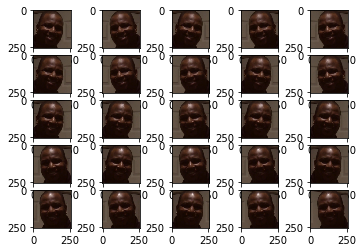

In [20]:
import matplotlib.pyplot as plt

x_show = x.transpose(1,2,3,0)
x_show -= np.min(x_show)
x_show /= np.max(x_show)
def view(x, nrows=4, ncols=4):
    indices = np.linspace(0, len(x)-1, nrows*ncols) 
    for ind, i in enumerate(indices):
        plt.subplot(nrows,ncols,ind+1)
        plt.imshow(x[int(i),...,::-1])
    plt.show()

view(x_show, 5, 5)

In [21]:
for k,v in predictions.items():
    string = '{} : {:.4f} //'.format(k, np.mean(v))
    for proba in v:
        string += ' {:.4f}'.format(proba)
    print(string)

aassnaulhq.mp4 : 0.9893 // 0.9943 0.9978 0.9996 0.9963 1.0000 0.9806 0.9787 0.9673
aayfryxljh.mp4 : 0.0083 // 0.0003 0.0000 0.0003 0.0034 0.0000 0.0257 0.0212 0.0157
acazlolrpz.mp4 : 0.9170 // 0.9725 0.9653 0.9887 0.9027 0.9639 0.9450 0.9188 0.6787
adohdulfwb.mp4 : 0.0121 // 0.0000 0.0000 0.0001 0.0028 0.0000 0.0418 0.0299 0.0223
ahjnxtiamx.mp4 : 0.9847 // 1.0000 0.9996 1.0000 1.0000 1.0000 0.9603 0.9446 0.9732
ajiyrjfyzp.mp4 : 0.2898 // 0.1574 0.1915 0.2998 0.3086 0.2622 0.1838 0.2515 0.6636
aktnlyqpah.mp4 : 0.9900 // 1.0000 1.0000 1.0000 0.9994 1.0000 0.9756 0.9743 0.9710
alrtntfxtd.mp4 : 0.9800 // 0.9970 0.9977 0.9999 0.9687 0.9995 0.9754 0.9780 0.9239
aomqqjipcp.mp4 : 0.9753 // 1.0000 0.9991 0.9997 0.9210 1.0000 0.9753 0.9339 0.9734
apedduehoy.mp4 : 0.0274 // 0.0076 0.0257 0.0083 0.0156 0.0005 0.0372 0.1100 0.0141
apvzjkvnwn.mp4 : 0.0108 // 0.0000 0.0016 0.0000 0.0005 0.0000 0.0416 0.0223 0.0199
aqrsylrzgi.mp4 : 0.8885 // 0.9859 0.8618 0.9722 0.8217 0.9539 0.9280 0.8605 0.7243
axfh

In [22]:
del model
for modeldict in models_3d:
    del modeldict['model']
    del modeldict
del models_3d
gc.collect()

38466

# Fill in missing predictions with 0.5

In [23]:
for videopath in videopaths:
    videoname = os.path.basename(videopath)
    if videoname not in predictions:
        predictions[videoname] = [DEFAULT_MISSING_PRED]

# Calculate ensembled prediction & clamp

In [24]:
preds_ensembled = {}

for videopath, pred in predictions.items():
    #print(f"{videopath} Got {len(pred)} predictions")
    preds_ensembled[videopath] = np.clip(np.mean(pred), PROB_MIN, PROB_MAX)

# Save predictions

In [25]:
!rm -rf /kaggle/working/*

In [26]:
print(f"{len(preds_ensembled)} predictions")
with open("submission.csv", 'w') as f:
    f.write("filename,label\n")
    for filename, label in preds_ensembled.items():
        f.write(f"{filename},{label}\n")

400 predictions


In [27]:
!head -10 submission.csv

filename,label
aassnaulhq.mp4,0.9893372505903244
aayfryxljh.mp4,0.00831242767162621
acazlolrpz.mp4,0.9169684611260891
adohdulfwb.mp4,0.012112685013562441
ahjnxtiamx.mp4,0.9847113415598869
ajiyrjfyzp.mp4,0.2897782288491726
aktnlyqpah.mp4,0.9900393486022949
alrtntfxtd.mp4,0.9800057634711266
aomqqjipcp.mp4,0.9752924665808678
